# MNIST Example with Data Logging in DataFed

## Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import ast
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

sys.path.append(os.path.abspath(".."))
sys.path.append(os.path.abspath("../src"))

from m3util.util.IO import make_folder
from datafed_torchflow.computer import get_system_info
from datafed_torchflow.pytorch import TorchLogger


## Paramters to Update

## Builds the CNN

In [2]:
# Define the CNN architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)  # Output layer for 10 classes (digits 0-9)
    
    def forward(self, x):
        # Apply convolutional layers with ReLU and max pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        # Flatten the output
        x = x.view(-1, 64 * 7 * 7)

        # Apply fully connected layers with ReLU and final output
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x


## Define transformations for data preprocessing

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize with mean and std of MNIST dataset
])


## Load the MNIST dataset


In [4]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)


## Instantiate the model, loss function, and optimizer, and DataFed TorchLogger


In [5]:
suffix = "100124"
notebook_path = '/home/jg3837/DataFed_TorchFlow/DataFed_TorchFlow/examples/Model_logger.ipynb'


criterion = nn.CrossEntropyLoss()  # Loss function for multi-class classification


optimizer = optim.Adam(SimpleCNN().parameters(), lr=0.001)  # Adam optimizer

model_dict = {"SimpleCNN":SimpleCNN(), "optimizer": optimizer}

In [6]:
torchlogger = TorchLogger(model_dict= model_dict, DataFed_path = f"2024_test_pytorch/delete_me/{suffix}", 
                          script_path=notebook_path, input_data_shape = train_dataset[0][0].shape,
                          local_model_path=f"examples/model/{suffix}", verbose=True)

Unable to connect to pypi: <Fault -32500: 'RuntimeError: PyPI no longer supports the XMLRPC package_releases method. Use JSON or Simple API instead. See https://warehouse.pypa.io/api-reference/xml-rpc.html#deprecated-methods for more information.'>
Success! You have been authenticated into DataFed as: u/jg3837
Success! You have set up the Globus endpoint dd579508-6fdb-11ef-aae2-7d6f43498e7d.
Uploading notebook /home/jg3837/DataFed_TorchFlow/DataFed_TorchFlow/examples/Model_logger.ipynb to DataFed...
Success! You have set up the Globus endpoint dd579508-6fdb-11ef-aae2-7d6f43498e7d.
Success! You have been authenticated into DataFed as: u/jg3837


## Training function


In [7]:
# Function to visualize embeddings using PCA
def visualize_embeddings(model, data_loader, device, embedding_file_path):
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(device)
            output = model.conv1(data)
            embeddings.append(output.cpu().numpy())
            labels.append(target.numpy())

    embeddings = np.concatenate(embeddings, axis=0)
    labels = np.concatenate(labels, axis=0)

    # Use PCA for visualization
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings.reshape(embeddings.shape[0], -1))

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='jet', s=5)
    plt.colorbar(scatter)
    plt.title("PCA of CNN Embeddings")
    plt.savefig(embedding_file_path)

# Function to visualize reconstruction 
def visualize_reconstruction(model, data_loader, device, reconstruction_file_path):
    model.eval()
    examples = enumerate(data_loader)
    batch_idx, (example_data, example_targets) = next(examples)

    example_data = example_data.to(device)
    output = model(example_data)
    pred = output.argmax(dim=1, keepdim=True).cpu()

    fig = plt.figure(figsize=(12, 6))
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        plt.tight_layout()
        plt.imshow(example_data[i].cpu().numpy().squeeze(), cmap='gray', interpolation='none')
        plt.title(f"Prediction: {pred[i].item()}")
        plt.xticks([])
        plt.yticks([])
    plt.savefig(reconstruction_file_path)


In [8]:
def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()  # Set the model to training mode
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()  # Zero the gradients

        # Forward pass
        output = model(data)
        loss = criterion(output, target)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
            
    
    weights_file_path = f"model/{suffix}/weights/weights_epoch_{epoch}.pkl"
    embedding_file_path = f"model/{suffix}/embeddings/embeddings_epoch_{epoch}.png"
    reconstruction_file_path = f"model/{suffix}/reconstructions/reconstructions_epoch_{epoch}.png"


    
    make_folder(weights_file_path.rsplit("/",1)[0])
    make_folder(embedding_file_path.rsplit("/",1)[0])
    make_folder(reconstruction_file_path.rsplit("/",1)[0])

    
    
    torch.save(model.state_dict(),weights_file_path) 
    
    
    
    # Visualize model embeddings and reconstruction
    visualize_embeddings(model, test_loader, device, embedding_file_path)
    visualize_reconstruction(model, test_loader, device, reconstruction_file_path)
        
    
          
    torchlogger.save(f'MNSIT_epoch_{epoch}_loss_{loss.item():.4e}.zip', epoch=epoch, training_loss=loss.item(),
                     weights_file_path=weights_file_path, embedding_file_path = embedding_file_path, 
                     reconstruction_file_path = reconstruction_file_path, local_vars=list(locals().items()), model_hyperparameters={"criterion":criterion})


## Testing function

In [9]:
def test(model, device, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    correct = 0
    with torch.no_grad():  # Disable gradient calculation for evaluation
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            # Forward pass
            output = model(data)
            test_loss += criterion(output, target).item()  # Sum up the batch loss
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)

    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} '
          f'({accuracy:.2f}%)\n')


## Instantiate the DataFed Configuration

## Train Model

In [10]:
model = SimpleCNN()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.307980
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.317364
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.278728
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.329607
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.311841
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.315050
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.306071
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.286987
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.313604
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.316524
Success! You have set up the Globus endpoint dd579508-6fdb-11ef-aae2-7d6f43498e7d.
Success! You have been authenticated into DataFed as: u/jg3837

Test set: Average loss: 0.0023, Accuracy: 1032/10000 (10.32%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.302257
Train Epoch: 2 [6400/60000 (11%)]	Loss: 2.286117
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2.310225
Train Epoch: 2 [19200/60000 (32%)]	Loss: 2.305956
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2.295257
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.298926
Tr

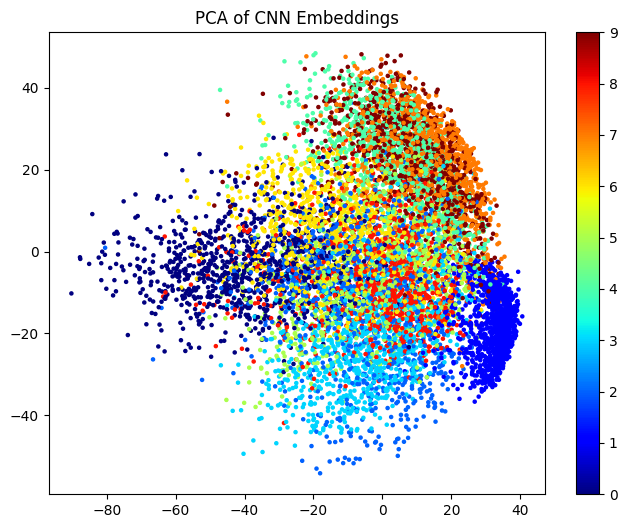

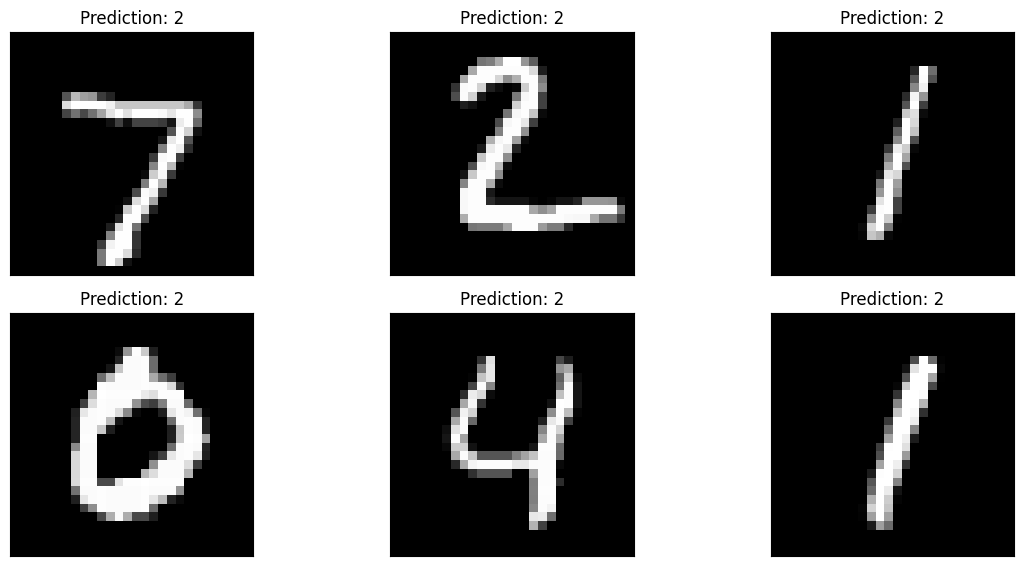

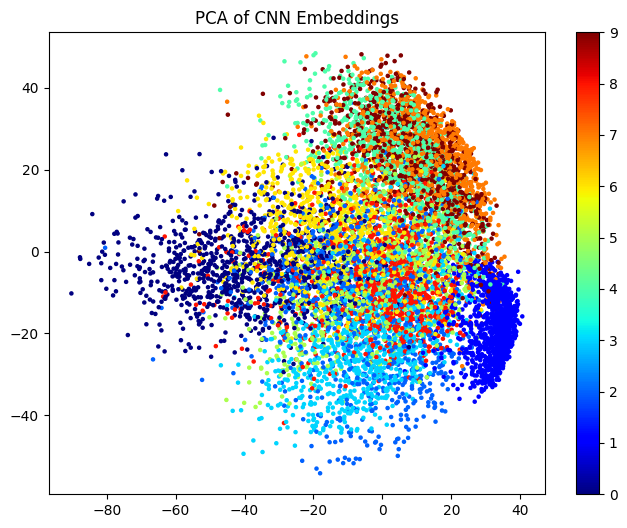

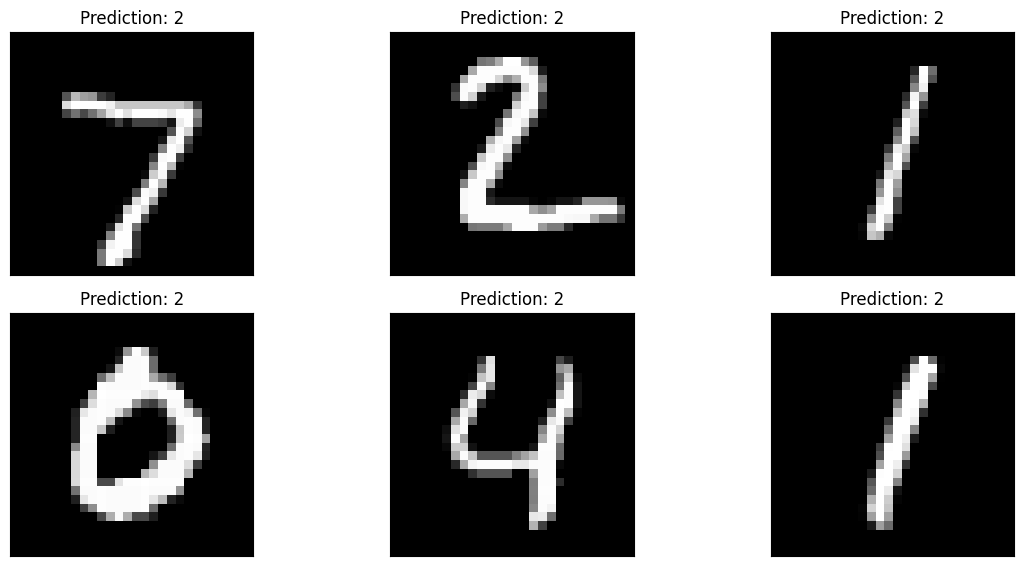

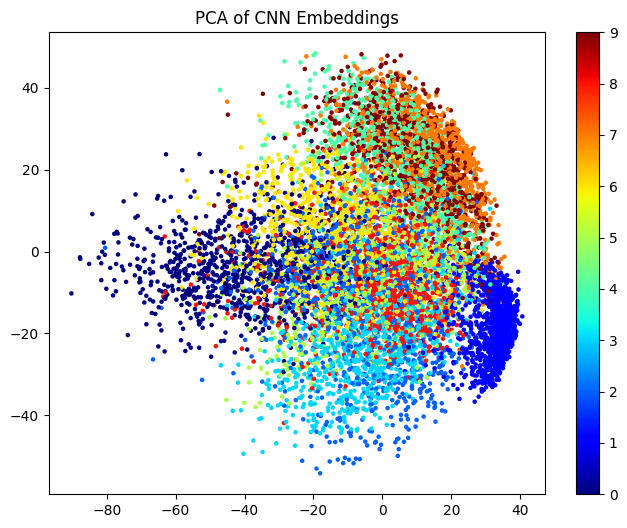

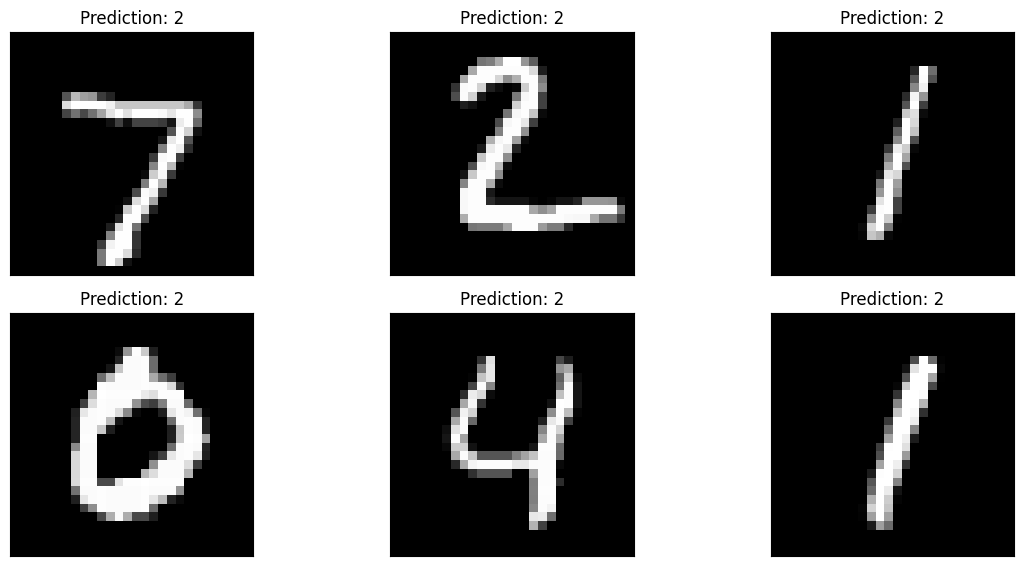

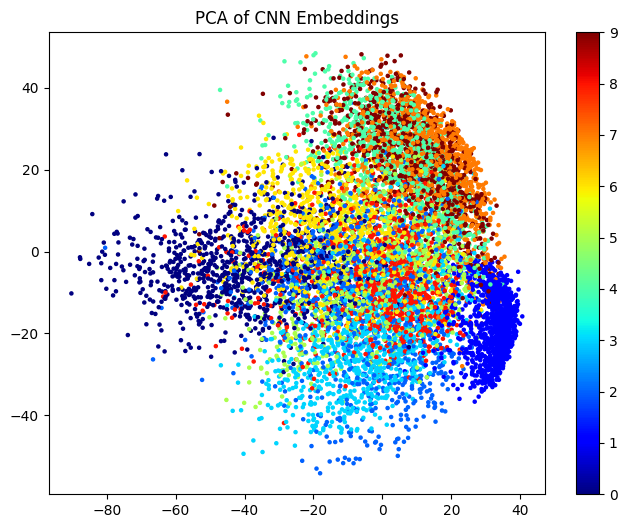

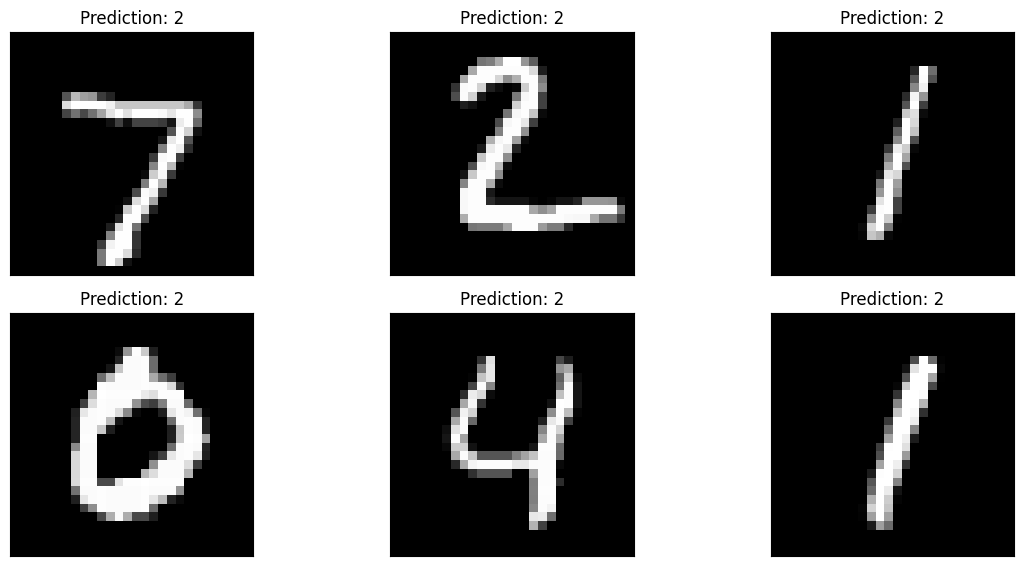

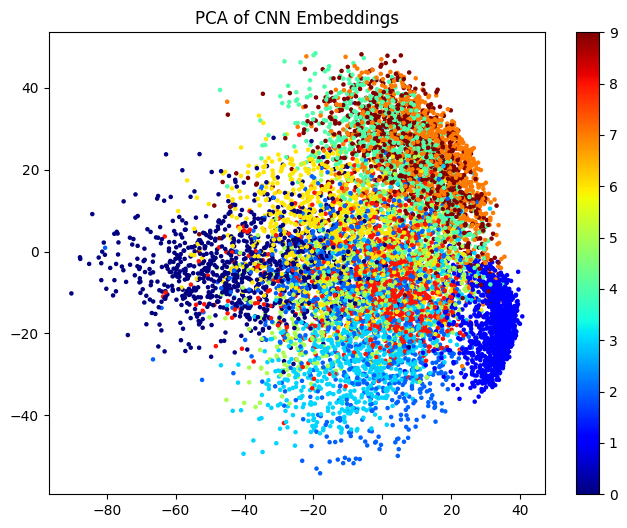

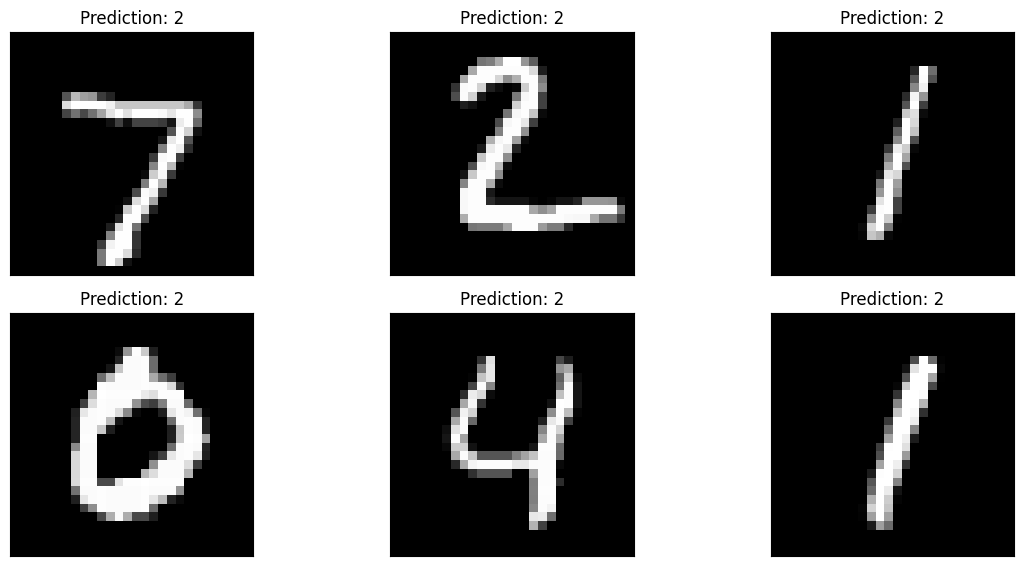

In [11]:
# Train and test the CNN
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

n_epochs = 5
for epoch in range(1, n_epochs + 1):
    train(model, device, train_loader, optimizer, criterion, epoch)
    test(model, device, test_loader, criterion)